# FFTW

這一節，我們介紹如何使用 package FFTW。

In [2]:
using FFTW
using LinearAlgebra
using Plots

## fft 的輸入方式
fft 是一個將函數值轉成傅立葉係數的指令，因此，我們在 fft() 的括號裡放入函數值所形成的向量。

### 1D fft

下面的兩個例子告訴我們，當資料是一維的時候輸入行向量或列向量，結果是一樣的。

In [2]:
fft([0; 1; 2; 1])

4-element Array{Complex{Float64},1}:
  4.0 + 0.0im
 -2.0 + 0.0im
  0.0 + 0.0im
 -2.0 + 0.0im

In [3]:
fft([0, 1, 2, 1])

4-element Array{Complex{Float64},1}:
  4.0 + 0.0im
 -2.0 + 0.0im
  0.0 + 0.0im
 -2.0 + 0.0im

### 2D fft

下列的例子我們跟 matlab 中的 fft2 比較，結果是一樣的。

In [4]:
[0 0 0 0; 1 1 1 1; 2 2 2 2; 1 1 1 1]

4×4 Array{Int64,2}:
 0  0  0  0
 1  1  1  1
 2  2  2  2
 1  1  1  1

In [2]:
fft([0 0 0 0; 1 1 1 1; 2 2 2 2; 1 1 1 1])

4×4 Array{Complex{Float64},2}:
 16.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 -8.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 -8.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im

從結果可以看出 Julia 的 fft，做矩陣的傅立葉轉換時，是先做行向量，並將結果依照行向量儲存在該行。全部做完一次之後再做列向量，再將該列的結果儲存在該列。 

我們把步驟拆解開來看，

1. 上例中，先做 fft([0;1;2;1]) = [4;-2;0;-2]。矩陣中四行都做完會得到

In [8]:
[4 4 4 4; -2 -2 -2 -2; 0 0 0 0; -2 -2 -2 -2]

4×4 Array{Int64,2}:
  4   4   4   4
 -2  -2  -2  -2
  0   0   0   0
 -2  -2  -2  -2

2. 接下來再做列向量。由於現在每一列都是常數函數，所以我們可以預期它的結果只有在第一個傅立葉係數有值，其他為 0。(第一個傅立葉係數 $\hat{f}_0$ 儲存的是函數常數的部分，也就是 $e^0$ 的係數)。底下是 f(x) = 4 的傅立葉轉換結果，結果是 $4 \times N$，$N$ 是取點的各數，在這裡是取樣 4 個點 (細節在稍後的小節中會提到)。其他列的計算結果雷同，fft([-2 -2 -2 -2]) = [-8 0 0 0], fft([0 0 0 0]) = [0 0 0 0]。

In [9]:
fft([4 4 4 4])

1×4 Array{Complex{Float64},2}:
 16.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im

把每一列的結果按照每一列的順序排好就會得到

In [10]:
[16 0 0 0; -8 0 0 0; 0 0 0 0; -8 0 0 0]

4×4 Array{Int64,2}:
 16  0  0  0
 -8  0  0  0
  0  0  0  0
 -8  0  0  0

## FFT 的運算時間
下列的兩個例子告訴我們，fft 這個內建的函數運算速度很快，將一個 (2^17)*1 的向量轉成傅立葉係數不會超過 0.2 秒。另一個需要注意的地方是當我們使用 @time 計算運算時間時，需要多算幾次再取平均。

如果向量的長度為 2 的倍數，運算速度會比較快

In [4]:
x = randn(2^17)
@time y = fft(x);
x = randn(2^17)
@time y = fft(x);
x = randn(2^17)
@time y = fft(x);
x = randn(2^17)
@time y = fft(x);

  0.103600 seconds (67.72 k allocations: 7.558 MiB)
  0.043618 seconds (60 allocations: 4.003 MiB)
  0.040007 seconds (60 allocations: 4.003 MiB)
  0.039623 seconds (60 allocations: 4.003 MiB)


如果向量的長度不是 2 的倍數，運算速度會比較慢

In [5]:
x = randn(92993)
@time y = fft(x);
x = randn(92993)
@time y = fft(x);
x = randn(92993)
@time y = fft(x);
x = randn(92993)
@time y = fft(x);

  0.295042 seconds (60 allocations: 2.841 MiB, 2.11% gc time)
  0.273192 seconds (60 allocations: 2.841 MiB)
  0.266714 seconds (60 allocations: 2.841 MiB)
  0.267703 seconds (60 allocations: 2.841 MiB)


## FFT 的運算量
FFT 的運算量約為 nlog(n), n 為向量長度。

In [2]:
function cpt(k)
    for ii = 1:1
        x = randn(10^k);
        y = fft(x);
    end
end

cpt (generic function with 1 method)

用 @timed 計時可以把時間存起來，@timed 的運算結果是一個向量，計算時間儲存在向量的第二個值。

我們把 n = $10^2$ ~ $10^8$ 計算的結果分別儲存在 x2 ~ x8 中。

In [46]:
@timed cpt(8)

(nothing, 32.1672114, 4000003568, 0.176620498, Base.GC_Diff(4000003568, 3, 0, 59, 0, 0, 176620498, 3, 2))

In [3]:
x2 = @timed cpt(2)
x3 = @timed cpt(3)
x4 = @timed cpt(4)
x5 = @timed cpt(5)
x6 = @timed cpt(6)
x7 = @timed cpt(7)
x8 = @timed cpt(8)

(nothing, 66.207427399, 4000003568, 0.380932002, Base.GC_Diff(4000003568, 3, 0, 59, 0, 0, 380932002, 3, 3))

為了方便畫圖，我們把計算的時間存在 y1 中，y2為 nlog(n)，n = $10^2$ ~ $10^8$。

In [4]:
y1 = [x2[2], x3[2], x4[2], x5[2], x6[2], x7[2], x8[2]]

7-element Array{Float64,1}:
  1.4371328  
  0.0015217  
  0.0034044  
  0.0431045  
  0.6690196  
  5.866769599
 66.207427399

In [5]:
y2 = [2*10^2, 3*10^3, 4*10^4, 5*10^5, 6*10^6, 7*10^7, 8*10^8]

7-element Array{Int64,1}:
       200
      3000
     40000
    500000
   6000000
  70000000
 800000000

In [6]:
x = [10^2, 10^3, 10^4, 10^5, 10^6, 10^7, 10^8]

7-element Array{Int64,1}:
       100
      1000
     10000
    100000
   1000000
  10000000
 100000000

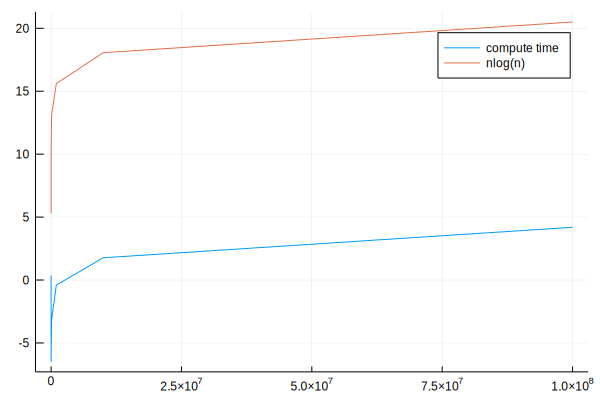

In [10]:
p = plot(x,log.(y1),label="compute time")
plot!(p,x,log.(y2),label="nlog(n)")

我們將計算所花的時間和 nlog(n) 分別取對數畫在同一張圖上，會發現斜率幾乎一樣。因此 fft 的運算量約為 nlog(n)。

補充：

我們可以利用 varinfo() 查看所有變數

In [59]:
varinfo()

| name |       size | summary                                           |
|:---- | ----------:|:------------------------------------------------- |
| Base |            | Module                                            |
| Core |            | Module                                            |
| Main |            | Module                                            |
| cpt  |    0 bytes | typeof(cpt)                                       |
| p    | 34.366 KiB | Plots.Plot{Plots.GRBackend}                       |
| x    |   96 bytes | 7-element Array{Int64,1}                          |
| x2   |   96 bytes | Tuple{Nothing,Float64,Int64,Float64,Base.GC_Diff} |
| x3   |   96 bytes | Tuple{Nothing,Float64,Int64,Float64,Base.GC_Diff} |
| x4   |   96 bytes | Tuple{Nothing,Float64,Int64,Float64,Base.GC_Diff} |
| x5   |   96 bytes | Tuple{Nothing,Float64,Int64,Float64,Base.GC_Diff} |
| x6   |   96 bytes | Tuple{Nothing,Float64,Int64,Float64,Base.GC_Diff} |
| x7   |   96 bytes | Tuple{Nothing,Float64,Int64,Float64,Base.GC_Diff} |
| x8   |   96 bytes | Tuple{Nothing,Float64,Int64,Float64,Base.GC_Diff} |
| y    |   88 bytes | 6-element Array{Int64,1}                          |
| y1   |   96 bytes | 7-element Array{Float64,1}                        |
| y2   |   96 bytes | 7-element Array{Int64,1}                          |


## fft 的準確度
下列兩個例子告訴我們，使用 fft 求傅立葉係數的誤差會在機器誤差 ($10^{-14}$) 以下。

我們將要轉換的值儲存在變數 a 中，利用 fft(a) 取其傅立葉係數，再利用 ifft(fft(a)) 轉回原來的函數值。

如果 fft 與 ifft 這兩個函數可以很準確的把函數值轉成傅立葉係數，再轉回原函數，那麼 ifft(fft(a)) 與 a 的值差距應該要很小。

因此我們用 norm 計算 ifft(fft(a)) 與 a 之間的誤差。下列兩個結果顯示，轉換的誤差會小於機器誤差。

Julia 中，norm 這個函數可以用來算向量與矩陣的範數，

norm(A, Inf) 用來計算 A 的 infinity norm，即取出向量中絕對值最大的元素。

norm(A, p) 用來計算 A 的 p norm，$||A||_p = (\sum_{i = 1}^n |a_i|^p)^{1/p}$，其中 $a_i$ 是 A 中的元素，A 的長度為 n。

norm(A) 是用預設的值，算的是 2 - norm。

我們用兩個例子來檢驗。令 a 是複數，實部與虛部都取亂數。
1. rand(8) 是從 0 到 1 之間取 8 個亂數，值為小數。
2. rand(-10:10,8) 是從 -10 到 10 之間取 8 個亂數，值為整數。

In [18]:
a = rand(8) + im*rand(8);
norm(ifft(fft(a)) - a)

1.9229626863835638e-16

In [7]:
a = rand(-10:10, 8) + im*rand(-10:10, 8);
norm(ifft(fft(a)) - a)

2.2644195468014703e-15

## 用實際的例子轉換看看
我們用 $y = \sin(x)$ 和 $y = \cos(x)$ 來看看 fft 是怎麼運作的。

$\sin(x)$ 是一個週期函數，週期是 $2\pi$
1. 我們在 $[0, 2\pi]$ 之間取 N+1 個點。於是我們有 x = range(0,stop=2*pi,length=N+1); 到這裡，x 是一個長度為 N+1 的向量，最小值是 0，最大值是 $2\pi$。
2. 必須注意的是 $\sin(0)$ 和 $\sin(2\pi)$ 指的是相同的點，他們都等於 0。所以我們要把 x 向量的最後一個點去掉，即 x = x[1:N];

In [12]:
N=100;
x = range(0,stop=2*pi,length=N+1);
x = x[1:N];

接著我們計算 $y = \sin(x)$ 的傅立葉係數。
1. 先求出 $\sin(x)$ 的值，並儲存在變數 fs 中。由於 x 是一個向量，因此要用 fs = sin.(x)，而不是 fs = sin(x);
2. 將 fs 轉成傅立葉係數，並儲存在 fs_hat 中。
3. 用 plot 指令畫出係數中虛部的部分。

我們稍微計算一下，根據 Euler's formula，$\sin(\theta) = \frac{e^{i\theta} - e^{-i\theta}}{2i} = \frac{1}{2}(-ie^{i\theta} + ie^{-i\theta})$

數學上，離散傅立葉轉換的公式是這樣的：

傅立葉係數(fft(f))為 $\hat{f}_{k} = \frac{2 \pi}{N} \sum_{j = 1}^{N} e^{-i k x_j} f_j$，其中 $N$ 為 $[0,2\pi)$ 間點的個數。

而 ifft(fft(f)) 為 ${f}_{j} = \frac{1}{2 \pi} \sum_{k = -N/2 + 1}^{N/2} e^{i k x_j} \hat{f}_{k}$

再和離散傅立葉轉換的公式相對照，$\sin(\theta) = \frac{1}{2}(-ie^{i\theta} + ie^{-i\theta}) = \frac{1}{2 \pi}(-i \pi e^{i\theta} + i \pi e^{-i\theta} )$，可得傅立葉係數 $\hat{f}_1 = -i \pi$, $\hat{f}_{-1} = i \pi$，其他係數為零。

但，事實上，Julia fft(f) 與 ifft(fft(f)) 的運作方式是：

傅立葉係數(fft(f))為 $\hat{f}_{k} = \sum_{j = 1}^{N} e^{-i k x_j} f_j$，其中 $N$ 為 $[0,2\pi)$ 間點的個數。

而 ifft(fft(f)) 為 ${f}_{j} = \frac{1}{N} \sum_{k = -N/2 + 1}^{N/2} e^{i k x_j} \hat{f}_{k}$

由 $\sin(\theta) = \frac{1}{2}(-ie^{i\theta} + ie^{-i\theta}) = \frac{1}{N}(\frac{-i N}{2} e^{i\theta} + \frac{i N}{2} e^{-i\theta} )$，可得傅立葉係數 $\hat{f}_1 = \frac{-i N}{2}$, $\hat{f}_{-1} = \frac{i N}{2}$，其他係數為零。

最後將係數畫出來，我們用 imag 指令畫出傅立葉係數的虛部，會看到兩個峰值。


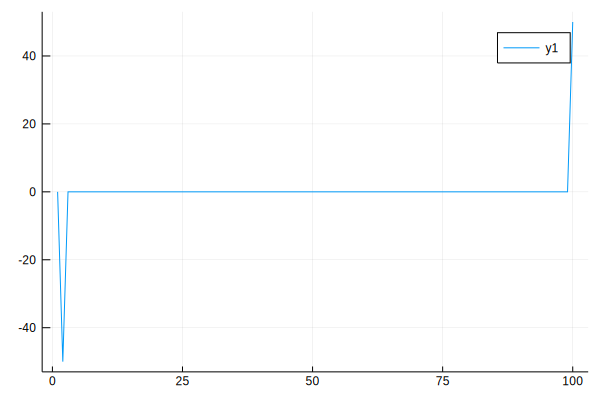

In [13]:
fs = sin.(x);
fs_hat = fft(fs);
plot(imag(fs_hat))

接著我們計算 $y = \cos(x)$ 的傅立葉係數。
1. 先求出 $\cos(x)$ 的值，並儲存在變數 fc 中。
2. 將 fc 轉成傅立葉係數，並儲存在 fc_hat 中。
3. 用 plot 指令畫出係數中實部的部分。

根據 Euler's formula，$\cos(\theta) = \frac{e^{i\theta} + e^{-i\theta}}{2} = \frac{1}{2}(ie^{i\theta} + ie^{-i\theta})$

再和離散傅立葉轉換的公式相對照，可得傅立葉係數 $\hat{f}_{1} = N/2$, $\hat{f}_{-1} = N/2$，其他係數為零。

最後將係數畫出來，我們用 real 指令畫出傅立葉係數的實部，會看到兩個峰值。

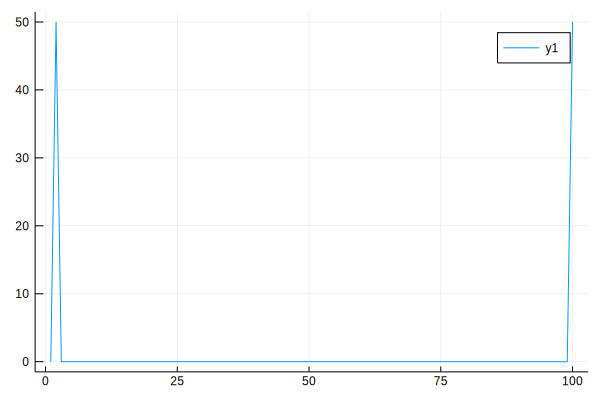

In [11]:
fc = cos.(x);
fc_hat = fft(fc);
plot(real(fc_hat))

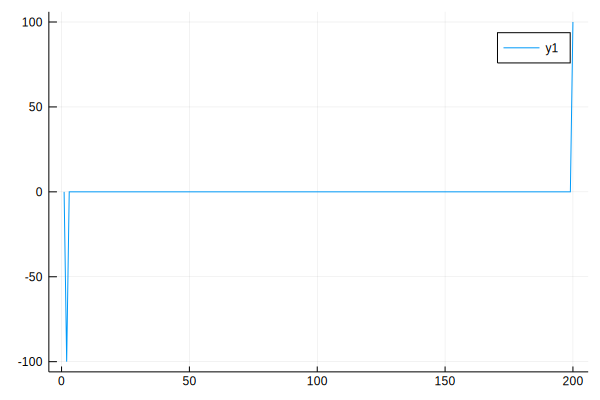

In [23]:
fss = sin.(x)+sin.(100*x);
fss_hat = fft(fss);
plot(imag(fss_hat))

## aliasing
假如我們試著畫出下列函數的傅立葉係數，會發現電腦只算出兩個傅立葉係數。但，理論上應該要有四個傅立葉係數，從圖上來看要有四個峰值。這是為什麼呢?

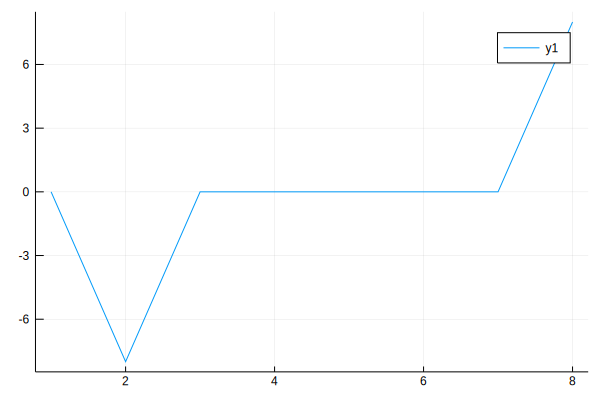

In [13]:
N=8;
x = range(0,stop=2*pi,length=N+1);
x = x[1:N];
fss = sin.(x)+sin.(9*x);
fss_hat = fft(fss);
plot(imag(fss_hat))

我們將 $\sin(x)$ 與 $\sin(9x)$的圖形分別畫出來。

$\sin(9x)$ 的週期是 $2\pi / 9$，因此 x 只取 8 個點對他來說太少了，沒辦法準確畫出函數。

我們把 $\sin(9x)$ 與 $\sin(x)$ 畫在一起，當我們只取 8 個點時，會發現取在 $\sin(9x)$ 上的點剛好落在 $\sin(x)$ 上。我們取到的資料沒辦法描述 $\sin(9x)$ 中高頻率的部分。因此，上圖實際上畫出的是 $y = 2 \sin(x)$ 的傅立葉係數。

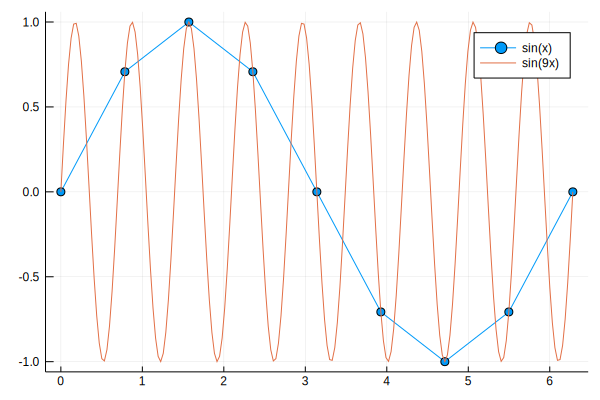

In [81]:
N=8;
x = range(0,stop=2*pi,length=N+1);
f = sin.(x);
p = plot(x,f,marker=:circle,label="sin(x)")
NN=200;
xx = range(0,stop=2*pi,length=NN+1);
g = sin.(9*xx);
plot!(p,xx,g,label="sin(9x)")

## zero-padding
我們想利用已知的函數 $f(x)$ 的傅立葉係數求 $f(x)^2$, 或更高次方的傅立葉係數。但直接將函數平方，會讓我們遇到一些問題，在次方小的時候用較少的傅立葉係數就可以表達一個函數，而在高次方時，需要更多的傅立葉係數。

當我們想求 $f(x) = \sin(3x)$ 的傅立葉係數時，根據 Euler's formula，
$\sin(3\theta) = \frac{e^{3i\theta} - e^{-3i\theta}}{2i} = \frac{1}{2}(-ie^{3i\theta} + ie^{-3i\theta})$
會算出兩個傅立葉係數，$\hat{f}_3$ 與 $\hat{f}_{-3}$。當我們取 N = 8 時，可以列出 $ k = 0, 1, 2, 3, 4, -3, -2, -1$ 的係數，因此 N = 8 在這個例子中是足夠的。

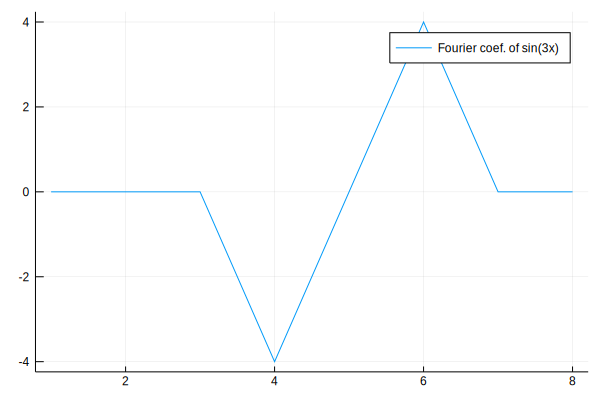

In [5]:
N=8;
x = range(0,stop=2*pi,length=N+1);
x = x[1:N];
fss = sin.(3*x);
fss_hat = fft(fss);
plot(imag(fss_hat),label="Fourier coef. of sin(3x)")

但是，當我們想算 $g(x) = \sin(3x)^2$ 的傅立葉係數時，N = 8 卻是不夠的。下面這張圖列出的傅立葉係數是錯誤的。

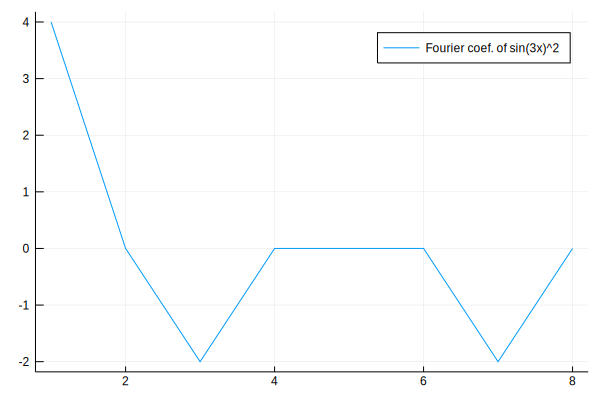

In [114]:
N=8;
x = range(0,stop=2*pi,length=N+1);
x = x[1:N];
fss = (sin.(3*x)).^2;
fss_hat = fft(fss);
plot(real(fss_hat),label="Fourier coef. of sin(3x)^2")

我們把  $g(x) = \sin(3x)^2$ 利用倍角公式整理一下，$g(x) = \sin(3x)^2 = \frac{1-\cos(6x)}{2}$。這會算出$\hat{f}_0$，$\hat{f}_6$ 與 $\hat{f}_{-6}$ 的傅立葉係數，因此至少會需要令 N = 16。

底下兩張圖，我們分別畫出 $\sin(3x)^2$ 與 $\frac{1-\cos(6x)}{2}$ 的傅立葉係數，結果是一樣的。

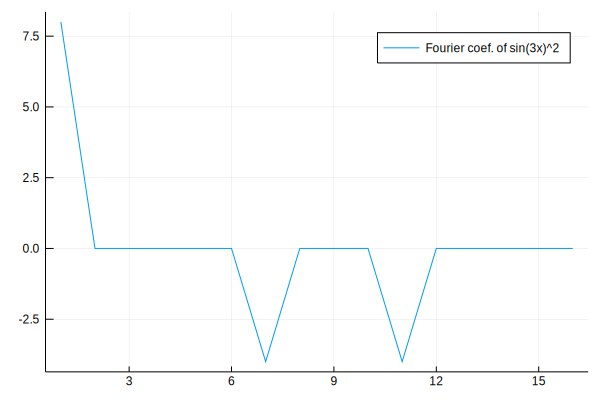

In [4]:
N=16;
x = range(0,stop=2*pi,length=N+1);
x = x[1:N];
fss = (sin.(3*x)).^2;
fss_hat = fft(fss);
plot(real(fss_hat),label="Fourier coef. of sin(3x)^2")

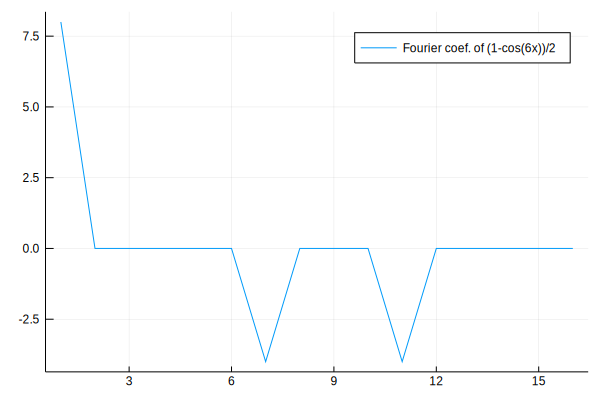

In [125]:
N=16;
x = range(0,stop=2*pi,length=N+1);
x = x[1:N];
fss = (ones(N,1)-cos.(6*x))./2;
fss_hat = fft(fss);
plot(real(fss_hat),label="Fourier coef. of (1-cos(6x))/2")

要怎麼樣才能從 $f(x) = sin(3x)$ 的傅立葉係數得到 $g(x) = sin(3x)^2$ 的傅立葉係數呢? 我們可以依照下列步驟試試：

1. zero - padding  

由前面幾個例子我們知道傅立葉係數的排序為 $\hat{f}_0, \hat{f}_1, \hat{f}_2, ...\hat{f}_{N/2 -1}, \hat{f}_{N/2}, \hat{f}_{-N/2 +1}, ..., \hat{f}_{-2}, \hat{f}_{-1}$.

如果以 N = 8 的例子來看就是 $\hat{f}_0, \hat{f}_1, \hat{f}_2, \hat{f}_3, \hat{f}_4, \hat{f}_{-3}, \hat{f}_{-2}, \hat{f}_{-1}$。而其中，當 $f(x) = \sin(3x)$ 時，$\hat{f}_{-3}$ 與 $\hat{f}_{3}$ 有值，其餘為 0。 

根據 Euler's formula，當 $g(x) = \sin(3x)^2$ 會算出 $\hat{f}_0$，$\hat{f}_6$ 與 $\hat{f}_{-6}$ 的傅立葉係數。所以我們要在原來的傅立葉係數中高頻率部分插入 0 的傅立葉係數。

$\hat{f}_0, \hat{f}_1, \hat{f}_2, \hat{f}_3, \hat{f}_4, (\hat{f}_5, \hat{f}_6, \hat{f}_7, \hat{f}_8, \hat{f}_{-7}, \hat{f}_{-6}, \hat{f}_{-5}, \hat{f}_{-4}), \hat{f}_{-3}, \hat{f}_{-2}, \hat{f}_{-1}$

括號部分即為所插入的高頻傅立葉係數。使用 append! 插入零向量時，可用 typeof() 檢查兩個向量的形式是否相同。

在我們將傅立葉係數轉回函數之前要注意到，傅立葉係數的個數 N 已經從原來的 8 變成 16。係數個數變成兩倍，因此我們也要將 zero - padding 之後的係數乘以 2，這樣才能轉回正確的函數 $\sin(3x)$。

這是因為 ifft(fft(f)) 為 ${f}_{j} = \frac{1}{N} \sum_{k = -N/2 + 1}^{N/2} e^{i k x_j} \hat{f}_{k}$，這個指令的前面會除以傅立葉係數的個數 $\frac{1}{N}$，係數的個數變成兩倍，係數也要變成兩倍。

2. do ifft

接著，將新的傅立葉係數轉回函數 $\sin(3x)$，此時的 $\sin(3x)$ 函數會比原先的 $\sin(3x)$ 多出八個點。轉回去之後再將函數平方，得到 $g(x) = \sin(3x)^2$。

3. do fft

這時候，我們將 $g(x)$ 做傅立葉轉換，就可以得到我們預期的傅立葉係數。

http://www.fftw.org/fftw3.pdf

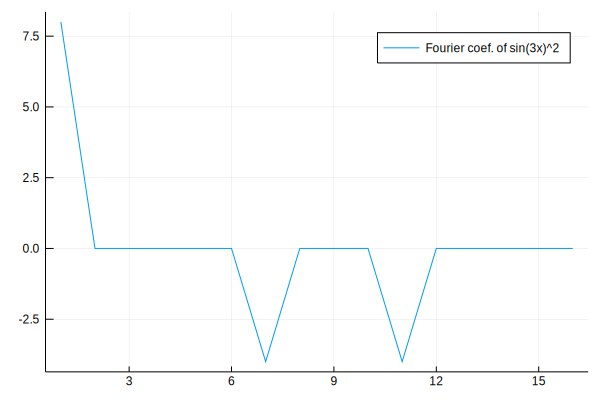

In [5]:
N=8;
x = range(0,stop=2*pi,length=N+1);
x = x[1:N];
f = sin.(3*x);
f_hat = fft(f)

# 1. zeropadding
b = append!(f_hat[1:4], zeros(8)+zeros(8)*im);
c = append!(b,f_hat[5:8]);
c = 2*c;
#typeof(f_hat)  # DataType

# 2. do ifft，to obtain function sin(3x)
fs = ifft(c);
g = fs.^2;

# 3. do fft
g_hat = fft(g)
plot(real(g_hat),label="Fourier coef. of sin(3x)^2")

#fss_hat = fss_hat[4:N+4]